In [ ]:
!pip install transformers datasets rouge-score nltk torch optuna bert-score


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import os
import re
import torch
import optuna
from datasets import load_dataset
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    PegasusTokenizer, PegasusForConditionalGeneration,
    AdamW
)
from torch.utils.data import DataLoader
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from bert_score import score
import matplotlib.pyplot as plt

# Ensuring necessary NLTK data is downloaded
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


/home/desai226/.local/lib/python3.9/site-packages/transformers/loss/loss_for_object_detection.py:28: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.2)
  from scipy.optimize import linear_sum_assignment


Using device: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/desai226/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/desai226/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/desai226/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Loading PEGASUS and T5 models
pegasus_model_name = "google/pegasus-large"
t5_model_name = "t5-base"

print(f"Loading PEGASUS model: {pegasus_model_name}")
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name).to(device)

print(f"Loading T5 model: {t5_model_name}")
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)


Loading PEGASUS model: google/pegasus-large


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading T5 model: t5-base


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

In [ ]:
# Removing rows with missing data
def remove_missing_data(dataset, columns):
    return dataset.filter(lambda x: all(x[col] is not None for col in columns))

# Function to Load and clean datasets
def load_and_clean_data():
    train_data = load_dataset("ragha92/FNS_Summarization", split="train")
    validation_data = load_dataset("ragha92/FNS_Summarization", split="validation")
    test_data = load_dataset("ragha92/FNS_Summarization", split="test")

    columns = ['Annual Reports', 'Gold Summaries']
    train_data = remove_missing_data(train_data, columns)
    validation_data = remove_missing_data(validation_data, columns)
    test_data = remove_missing_data(test_data, columns)

    return train_data, validation_data, test_data

train_data, validation_data, test_data = load_and_clean_data()
print("Datasets loaded and cleaned.")


Datasets loaded and cleaned.


In [ ]:
# Summarizing with PEGASUS
def summarize_with_pegasus(text, num_beams=5, max_length=256, min_length=50, length_penalty=1.0):
    inputs = pegasus_tokenizer(text, truncation=True, return_tensors="pt", max_length=1024).to(device)
    summary_ids = pegasus_model.generate(
        inputs['input_ids'],
        num_beams=num_beams,
        max_length=max_length,
        min_length=min_length,
        length_penalty=length_penalty,
        early_stopping=True
    )
    return pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


# Refining with T5
def refine_with_t5(text, num_beams=3, max_length=128, min_length=50, length_penalty=1.0):
    inputs = t5_tokenizer(f"summarize: {text}", return_tensors="pt", truncation=True, max_length=512).to(device)
    summary_ids = t5_model.generate(
        inputs['input_ids'],
        num_beams=num_beams,
        max_length=max_length,
        min_length=min_length,
        length_penalty=length_penalty,
        early_stopping=True
    )
    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


# Combined Summarization
def summarize_with_combined_models(text, pegasus_params, t5_params):
    pegasus_summary = summarize_with_pegasus(
        text,
        num_beams=pegasus_params['num_beams'],
        max_length=pegasus_params['max_length'],
        min_length=pegasus_params['min_length'],
        length_penalty=pegasus_params['length_penalty']
    )
    t5_summary = refine_with_t5(
        pegasus_summary,
        num_beams=t5_params['num_beams'],
        max_length=t5_params['max_length'],
        min_length=t5_params['min_length'],
        length_penalty=t5_params['length_penalty']
    )
    return t5_summary


In [ ]:
from nltk.tokenize import word_tokenize

# Ensuring NLTK tokenizer data is downloaded
nltk.download('punkt')

def evaluate_model_combined(dataset, pegasus_params, t5_params):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': [], 'bleu': [], 'meteor': [], 'bertscore': []}
    smooth = SmoothingFunction().method4

    references = []
    candidates = []

    for item in dataset:
        # Preprocessing and generating summaries
        article = preprocess_text(item['Annual Reports'])
        gold_summary = preprocess_text(item['Gold Summaries'])

        if article and gold_summary:
            # PEGASUS Summarization
            pegasus_summary = summarize_with_pegasus(
                article,
                num_beams=pegasus_params['num_beams'],
                max_length=pegasus_params['max_length'],
                min_length=pegasus_params['min_length'],
                length_penalty=pegasus_params['length_penalty']
            )

            # T5 Refinement
            refined_summary = refine_with_t5(
                pegasus_summary,
                num_beams=t5_params['num_beams'],
                max_length=t5_params['max_length'],
                min_length=t5_params['min_length'],
                length_penalty=t5_params['length_penalty']
            )

            # Append for BERTScore
            references.append(gold_summary)
            candidates.append(refined_summary)

            # ROUGE scores
            rouge_scores = scorer.score(gold_summary, refined_summary)
            scores['rouge1'].append(rouge_scores['rouge1'].fmeasure)
            scores['rouge2'].append(rouge_scores['rouge2'].fmeasure)
            scores['rougeL'].append(rouge_scores['rougeL'].fmeasure)

            # BLEU scores
            bleu = sentence_bleu(
                [gold_summary.split()], refined_summary.split(),
                smoothing_function=smooth
            )
            scores['bleu'].append(bleu)

            # METEOR scores
            tokenized_gold = word_tokenize(gold_summary)
            tokenized_summary = word_tokenize(refined_summary)
            meteor = meteor_score([tokenized_gold], tokenized_summary)
            scores['meteor'].append(meteor)

    # BERTScore
    P, R, F1 = score(candidates, references, lang="en", verbose=True)
    scores['bertscore'] = F1.numpy().tolist()

    # Calculating averages
    avg_scores = {metric: sum(values) / len(values) for metric, values in scores.items()}
    return avg_scores


[nltk_data] Downloading package punkt to /home/desai226/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

# Defining updated hyperparameters based on the best values you provided
pegasus_params = {
    'learning_rate': 1.3102880767975398e-05,
    'num_beams': 9,
    'length_penalty': 1.7649659369712785,
    'max_length': 512,
    'min_length': 100
}

t5_params = {
    'learning_rate': 0.00024891242378186854,
    'num_beams': 7,
    'length_penalty': 1.55871543453282,
    'max_length': 896,
    'min_length': 50
}


# best hyperparameters for evaluation
val_scores = evaluate_model_combined(validation_data, pegasus_params, t5_params)
print("Validation Metrics:", val_scores)

test_scores = evaluate_model_combined(test_data, pegasus_params, t5_params)
print("Test Metrics:", test_scores)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/8 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 5.32 seconds, 48.31 sentences/sec
Validation Metrics: {'rouge1': 0.12361237317525296, 'rouge2': 0.059666953027654526, 'rougeL': 0.08845053790097493, 'bleu': 0.021955356999341896, 'meteor': 0.07371575533563968, 'bertscore': 0.7823455836986289}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/8 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 5.02 seconds, 51.18 sentences/sec
Test Metrics: {'rouge1': 0.10181649916125496, 'rouge2': 0.044380596418247265, 'rougeL': 0.07180446142930309, 'bleu': 0.012253069485135607, 'meteor': 0.05935643888702709, 'bertscore': 0.7770058719100655}


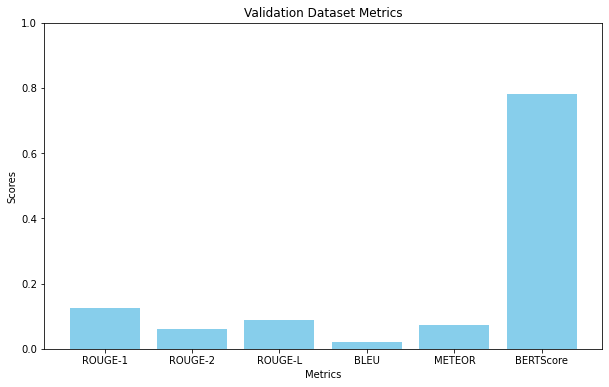

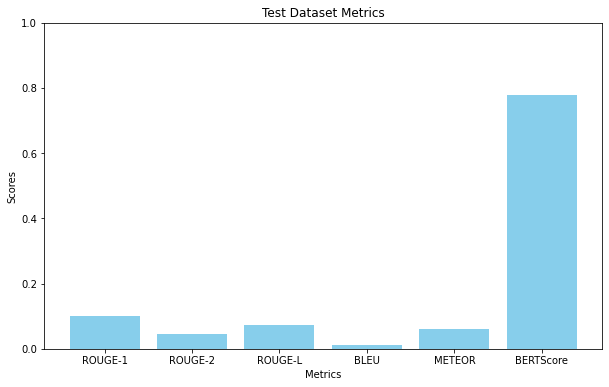

In [ ]:
def visualize_metrics(metrics, metric_names, dataset_type="Validation"):
    plt.figure(figsize=(10, 6))
    plt.bar(metric_names, metrics, color='skyblue')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(f'{dataset_type} Dataset Metrics')
    plt.ylim(0, 1)
    plt.show()

# Metrics for validation set
val_metrics = [val_scores['rouge1'], val_scores['rouge2'], val_scores['rougeL'], val_scores['bleu'], val_scores['meteor'], val_scores['bertscore']]
metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'METEOR', 'BERTScore']
visualize_metrics(val_metrics, metric_names, "Validation")

# Metrics for test set
test_metrics = [test_scores['rouge1'], test_scores['rouge2'], test_scores['rougeL'], test_scores['bleu'], test_scores['meteor'], test_scores['bertscore']]
visualize_metrics(test_metrics, metric_names, "Test")


In [ ]:
def display_sample_summaries(dataset, pegasus_params, t5_params, num_samples=3):
    """
    Display gold summaries and generated summaries for the first few records
    in the dataset using the Pegasus + T5 pipeline.

    Args:
        dataset (list): Dataset containing 'Annual Reports' and 'Gold Summaries'.
        pegasus_params (dict): Hyperparameters for Pegasus summarization.
        t5_params (dict): Hyperparameters for T5 refinement.
        num_samples (int): Number of samples to display.
    """
    sample_summaries = []

    for idx, item in enumerate(dataset):
        if idx >= num_samples:
            break

        # Extracting input text and gold summary
        input_text = preprocess_text(item['Annual Reports'])
        gold_summary = preprocess_text(item['Gold Summaries'])

        if not input_text or not gold_summary:
            continue

        # Generating Pegasus summary
        pegasus_summary = summarize_with_pegasus(
            input_text,
            num_beams=pegasus_params['num_beams'],
            max_length=pegasus_params['max_length'],
            min_length=pegasus_params['min_length'],
            length_penalty=pegasus_params['length_penalty']
        )

        # Refining Pegasus summary with T5
        generated_summary = refine_with_t5(
            pegasus_summary,
            num_beams=t5_params['num_beams'],
            max_length=t5_params['max_length'],
            min_length=t5_params['min_length'],
            length_penalty=t5_params['length_penalty']
        )

        # Storing summaries for display
        sample_summaries.append({
            'input_text': input_text,
            'gold_summary': gold_summary,
            'generated_summary': generated_summary
        })

    # Displaying summaries for each sample
    for idx, summary in enumerate(sample_summaries):
        print(f"Sample {idx + 1}:")
        print(f"Input Text (first 500 characters):\n{summary['input_text'][:500]}...")
        print(f"\nGold Summary (first 1500 characters):\n{summary['gold_summary'][:1500]}")
        print(f"\nGenerated Summary (first 1500 characters):\n{summary['generated_summary'][:1500]}")
        print("\n" + "=" * 50 + "\n")


# Displaying summaries for the first 3 records in the test dataset
display_sample_summaries(test_data, pegasus_params, t5_params, num_samples=3)


Sample 1:
Input Text (first 500 characters):
renew holding plc annual report account delivering engineering service uk infrastructure renew holding plc annual report account highlight engineering service revenue engineering service adjusted operating profit group order book including engineering service order book acquisition engineering service business amco fully integrated net debt line expectation following acquisition preexceptional item amortisation charge operational highlight financial highlight p p dividend per share p p adjusted ...

Gold Summary (first 1500 characters):
renew holding plc annual report account chief executive review renew positioned engineering service group supporting uk infrastructure significant year group organic growth acquisition amco achieved target shifting balance operation engineering service engineering service engineering service revenue account ongoing group revenue operating profit operating margin improved engineering service renew target key m